In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [ ]:
#read data
raspberry_price = pd.read_csv('/content/sample_data/Raspberry.csv', parse_dates=[0], index_col=0, squeeze=True)

In [ ]:
raspberry_price

Date
2010-11-19    2.40
2010-11-26    2.51
2010-12-03    2.24
2010-12-10    2.73
2010-12-17    3.32
              ... 
2022-01-28    2.67
2022-02-04    2.68
2022-02-11    2.48
2022-02-18    2.83
2022-02-25    2.79
Name: Price, Length: 589, dtype: float64

In [ ]:
#infer the frequency of the data
raspberry_price = raspberry_price.asfreq(pd.infer_freq(raspberry_price.index))

In [ ]:
start_date = datetime(2010,11,19)
end_date = datetime(2022,3,1)
lim_raspberry_price = raspberry_price[start_date:end_date]

In [ ]:
def plot_series(series):
  plt.figure(figsize=(10,4))
  plt.plot(lim_raspberry_price)
  plt.title('Raspberry Price per Year', fontsize=20)
  plt.ylabel('Price', fontsize=16)
  for year in range(start_date.year,end_date.year):
      plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

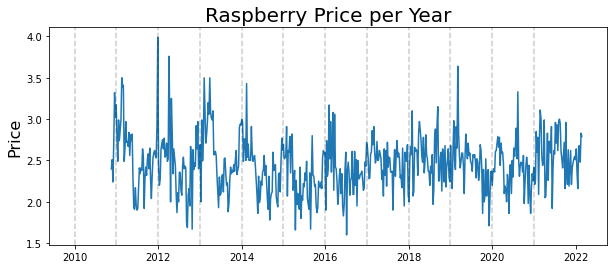

In [ ]:
plot_series(raspberry_price)

In [ ]:
result = adfuller(raspberry_price)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.611991
p-value: 0.000000


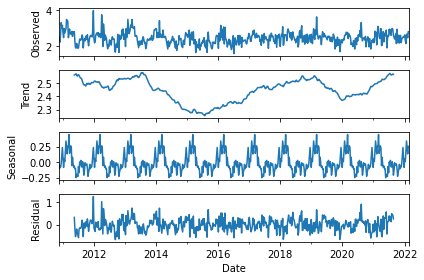

In [ ]:
seasonal_decomp = seasonal_decompose(raspberry_price,model='additive')
seasonal_decomp.plot()
pyplot.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


<BarContainer object of 20 artists>

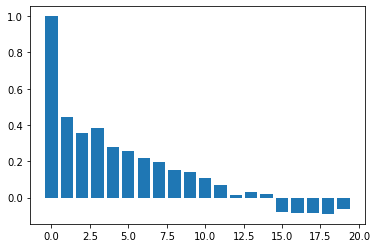

In [ ]:
acf_vals = acf(raspberry_price)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

From ACF we can see its in GP form. we can start with SARIMA model with MA(1). Based on the results we can update it

<BarContainer object of 20 artists>

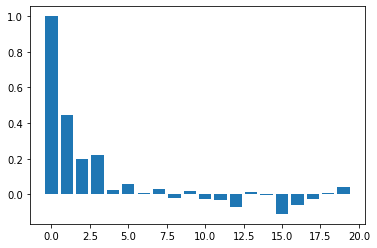

In [ ]:
pacf_vals = pacf(raspberry_price)
num_lags = 20
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [ ]:
train_end = datetime(2019,1,1)
val_end = datetime(2020,6,1)
test_end = datetime(2022,3,1)

train_data = lim_raspberry_price[:train_end]
val_data = lim_raspberry_price[train_end + timedelta(days=1):val_end]
test_data = lim_raspberry_price[val_end + timedelta(days=1):test_end]

In [ ]:
len(train_data),len(val_data),len(test_data)

(424, 74, 91)

In [ ]:
my_order = (4,0,0)
my_seasonal_order = (0, 1, 0, 52)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [ ]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 3.4035227298736572


In [ ]:
#summary of the model
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Price   No. Observations:                  417
Model:             SARIMAX(4, 0, 0)x(0, 1, 0, 52)   Log Likelihood                -160.306
Date:                            Thu, 11 Aug 2022   AIC                            330.611
Time:                                    02:14:29   BIC                            350.111
Sample:                                01-07-2011   HQIC                           338.361
                                     - 12-28-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1042      0.049      2.146      0.032       0.009       0.199
ar.L2          0.0176      0.052   

In [ ]:
#get the predictions and residuals
val_predictions = model_fit.forecast(len(val_data))
val_predictions = pd.Series(val_predictions, index=val_data.index)
val_residuals = val_data - val_predictions

Text(0, 0.5, 'Error')

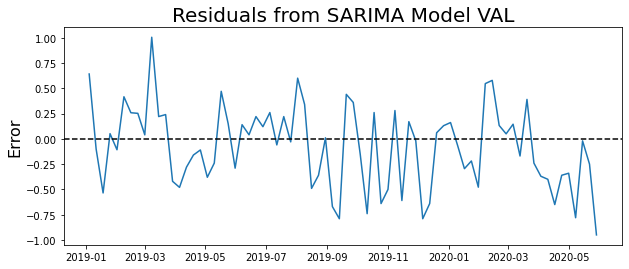

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(val_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model VAL', fontsize=20)
plt.ylabel('Error', fontsize=16)

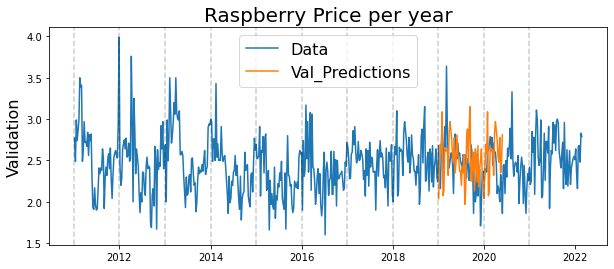

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(lim_raspberry_price)
plt.plot(val_predictions)

plt.legend(('Data', 'Val_Predictions'), fontsize=16)

plt.title('Raspberry Price per year', fontsize=20)
plt.ylabel('Validation', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions
print(predictions)
print(residuals)

Date
2020-06-05    2.57
2020-06-12    2.52
2020-06-19    2.37
2020-06-26    2.37
2020-07-03    2.20
              ... 
2022-01-28     NaN
2022-02-04     NaN
2022-02-11     NaN
2022-02-18     NaN
2022-02-25     NaN
Freq: W-FRI, Length: 91, dtype: float64
Date
2020-06-05   -0.13
2020-06-12   -0.07
2020-06-19   -0.27
2020-06-26    0.13
2020-07-03    0.10
              ... 
2022-01-28     NaN
2022-02-04     NaN
2022-02-11     NaN
2022-02-18     NaN
2022-02-25     NaN
Freq: W-FRI, Length: 91, dtype: float64


Text(0, 0.5, 'Error')

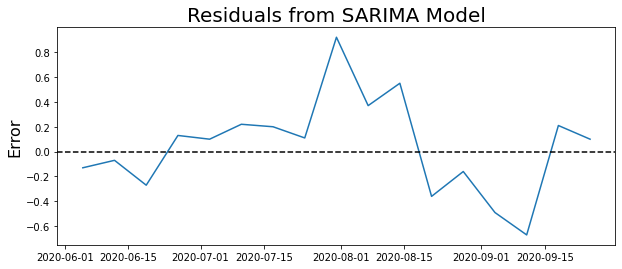

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

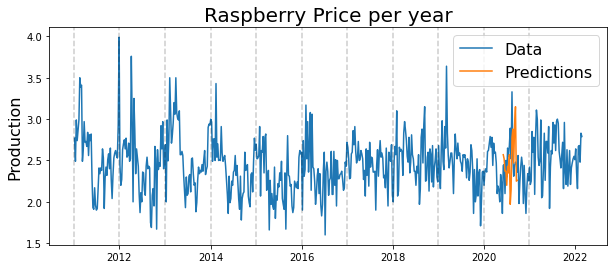

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(lim_raspberry_price)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Raspberry Price per year', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.1147


In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.3762195843656713


In [ ]:
rolling_predictions = test_data.copy()
for val_end in test_data.index:
    training_data = lim_raspberry_price[train_end + timedelta(days=1):val_end-timedelta(days=1)]
    model = SARIMAX(training_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[val_end] = pred

In [ ]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

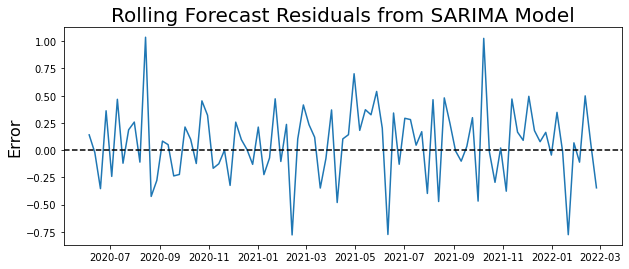

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

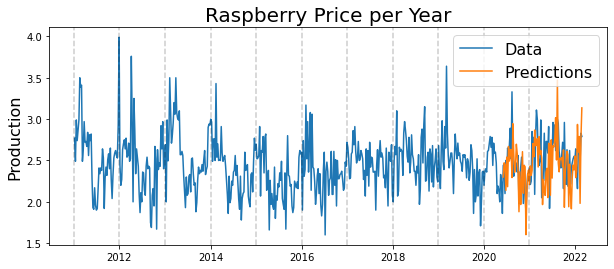

In [ ]:
plt.figure(figsize=(10,4))

plt.plot(lim_raspberry_price)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Raspberry Price per Year', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.1067


In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 0.3429980590932339


In [ ]:
ss_res = np.sum(rolling_residuals**2)
ss_tot = np.sum(test_data**2)
R_squared = 1 - (ss_res/ss_tot)
R_squared

0.9816222353750299